In [8]:
import numpy as np
import pandas as pd
import pymongo
from pymongo import MongoClient
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import pprint
import statsmodels.api as sm
import src.sentiment as snt
from data.get_data import get_download_links

from datetime import datetime
import boto3
import os
import re
import time
import subprocess

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
links_df = get_download_links()
links_df.head()

,month,link,downloaded,size_in_bytes,comment_count
0,2005-12,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
1,2006-01,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
2,2006-02,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
3,2006-03,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
4,2006-04,https://files.pushshift.io/reddit/comments/RC_...,False,0,0


In [3]:
client = MongoClient()
db = client['myreddit']
posts_all = db['posts_all']

yearmonths = sorted(posts_all.distinct('yearmonth'))

In [7]:
posts_all.find_one()

{'_id': ObjectId('5e554d246960e0b4e8de88fd'),
 'link_id': '2cnnc',
 'title': 'Smashing interview by Ron Paul on FOX!  "Just come home"',
 'score': 61,
 'is_self': False,
 'datetime': 1186379408.0,
 'sub': 'politics',
 'permalink': '/r/politics/comments/2cnnc/smashing_interview_by_ron_paul_on_fox_just_come/',
 'yearmonth': '2007-08'}

In [104]:
def posts_containing_phrase(phrase):
    pipe = [{'$match':{'title': re.compile(phrase, re.IGNORECASE),
                       'sub': 'politics'}}, 
            {'$group': {'_id': '$yearmonth', 
                        'total': {'$sum': '$score'}, 
                        'count': {'$sum': 1}}}, 
            {'$sort': {'_id': 1}}]
    cursor = posts_all.aggregate(pipeline=pipe)
    
    df = pd.DataFrame(list(cursor)).rename({'_id': 'yearmonth', 'total': 'total score'}, axis='columns')\
                                   .set_index('yearmonth')
    score_avg = df['total score'].mean()
    count_avg = df['count'].mean()
    df['normalized score'] = df['total score'].apply(lambda x: x/score_avg)
    df['normalized count'] = df['count'].apply(lambda x: x/count_avg)
    
    return df

In [105]:
rp_df = posts_containing_phrase('ron paul')

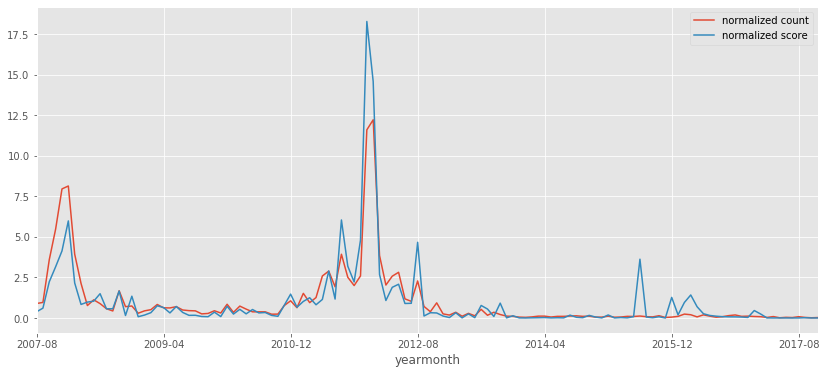

In [113]:
rp_df[['normalized count', 'normalized score']].plot(figsize=(14, 6))
# rp_df[['normalized count', 'normalized score']].plot()

In [107]:
sanders_df = posts_containing_phrase('sanders')

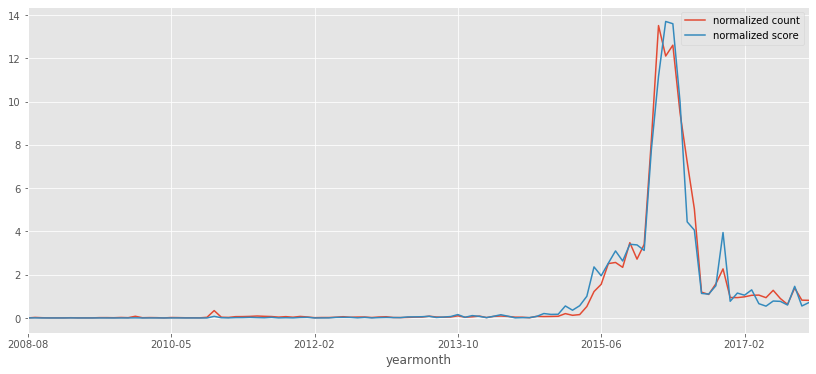

In [108]:
sanders_df[['normalized count', 'normalized score']].plot(figsize=(14, 6))

In [6]:
bernie_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='bernie')
    bernie_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

Num distinct link_ids: 0
2007-08
Num distinct link_ids: 0
Num distinct link_ids: 0
Num distinct link_ids: 3
Num distinct link_ids: 1
Num distinct link_ids: 1
Num distinct link_ids: 1
Num distinct link_ids: 0
Num distinct link_ids: 1
Num distinct link_ids: 0
Num distinct link_ids: 1
Num distinct link_ids: 2
Num distinct link_ids: 2
Num distinct link_ids: 8
Num distinct link_ids: 5
Num distinct link_ids: 2
Num distinct link_ids: 3
Num distinct link_ids: 3
Num distinct link_ids: 4
Num distinct link_ids: 11
Num distinct link_ids: 1
2009-04
Num distinct link_ids: 5
Num distinct link_ids: 8
Num distinct link_ids: 7
Num distinct link_ids: 5
Num distinct link_ids: 4
Num distinct link_ids: 10
Num distinct link_ids: 8
Num distinct link_ids: 16
Num distinct link_ids: 3
Num distinct link_ids: 7
Num distinct link_ids: 6
Num distinct link_ids: 6
Num distinct link_ids: 7
Num distinct link_ids: 6
Num distinct link_ids: 4
Num distinct link_ids: 1
Num distinct link_ids: 3
Num distinct link_ids: 1
Num di

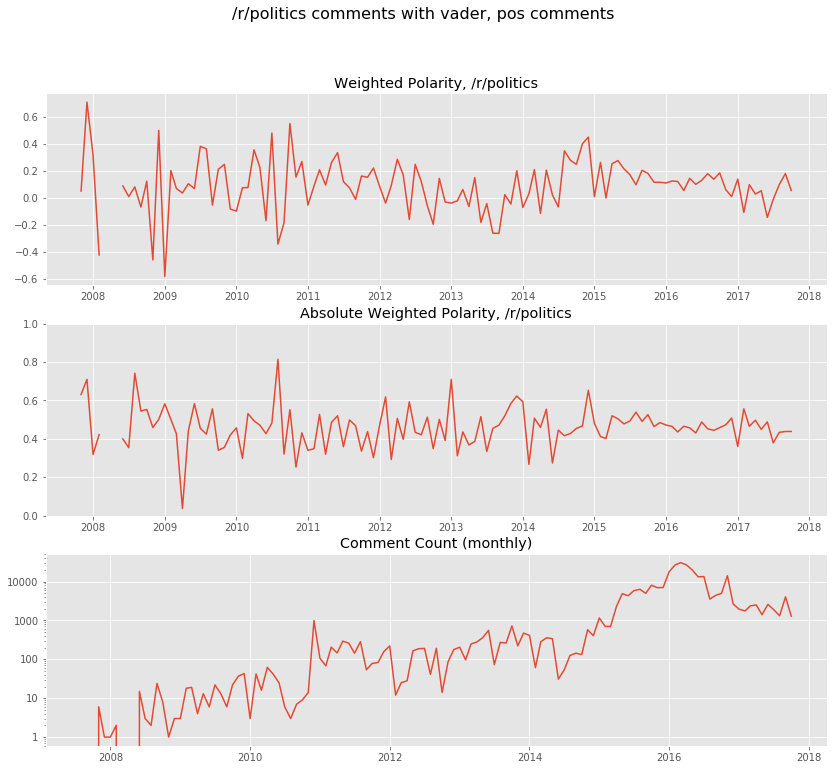

In [10]:
data_dict = bernie_sentiment_vader


fig, axes = plt.subplots(3, 1, figsize=(14, 12))

fig.suptitle('Bernie sentiment with vader', fontsize=16)
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
aawp = [v['avg_abs_wght_pol'] for _, v in sorted(data_dict.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(data_dict.items())]
ccnt = [v['comment_count'] for _, v in sorted(data_dict.items())]
awc = [v['avg_wordcount'] for _, v in sorted(data_dict.items())]

axes[0].plot(dates, awp)
# axes[0].set_ylim([0, 1])
axes[0].set_title('Weighted Polarity, /r/politics')

axes[1].plot(dates, aawp)
# aawp_trendline, params = make_trend_line(aawp)
# axes[0].plot(dates, aawp_trendline)
axes[1].set_ylim([0, 1])
axes[1].set_title('Absolute Weighted Polarity, /r/politics')

#     axes[1].plot(dates, aap)
#     axes[1].set_title('Absolute Comment Polarity')

axes[2].plot(dates, ccnt)
axes[2].set_title('Comment Count (monthly)')

axes[2].set_yscale('log')
axes[2].yaxis.set_major_formatter(ScalarFormatter())

In [14]:
trump_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='trump')
    trump_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


In [ ]:
trump_sentiment_vader

# N = 10
# np.convolve(trump_sentiment_vader, np.ones((N,))/N, mode='valid')

[None, 0.5719, -0.06274666666666666, 0.5661, 0.1075242857142857, -0.5461666666666667, -0.13330999999999998, 0.11975999999999998, 0.008892307692307687, -0.125, 0.2066361842105263, -0.2933303418803419, 0.0, -0.0231058823529412, 0.14176814159292045, 0.404275, None, 0.06255, -0.04487941176470588, -0.156775, -0.26558333333333334, 0.06870999999999997, 0.7541, -0.12974761904761903, 0.13426, 0.09654285714285715, 0.1510517857142857, -0.216440625, -0.23854444444444442, -0.06242857142857144, -0.29685342465753417, -0.37967, -0.49612, -0.26443481481481484, 0.15252500000000002, 0.02567083333333331, 0.0, -0.2207227272727272, -0.16522962962962962, 0.1406666666666666, -0.06302083333333332, -0.021804444444444453, -0.04907735849056604, 0.060387596048298534, -0.024795271898404515, 0.2462479574917093, -0.03117368421052631, -0.020161538461538477, 0.005262664165103195, 0.09988666666666665, 0.04803125000000001, -0.009811538461538458, 0.0009043809523809136, 0.12936704545454544, 0.12367309644670049, -0.18147272

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

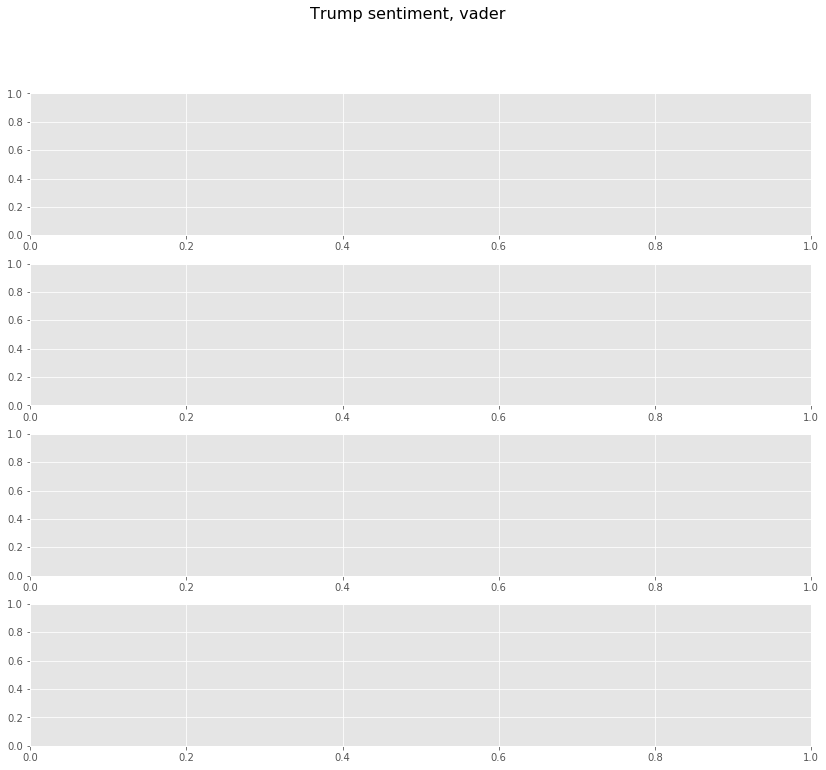

In [21]:
data_dict = trump_sentiment_vader
N = 10

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

fig.suptitle('Trump sentiment, vader', fontsize=16)
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
print(awp)
awp_ma = np.convolve(np.array(awp), np.ones((N,))/N, mode='valid')
aawp = [v['avg_abs_wght_pol'] for _, v in sorted(data_dict.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(data_dict.items())]
ccnt = [v['comment_count'] for _, v in sorted(data_dict.items())]
awc = [v['avg_wordcount'] for _, v in sorted(data_dict.items())]

axes[0].plot(dates, awp)
# axes[0].set_ylim([0, 1])
axes[0].set_title('Weighted Polarity')

axes[1].plot(dates, awp_ma)
axes[1].set_title('Weighted Polarity, moving average')

axes[2].plot(dates, aawp)
# aawp_trendline, params = make_trend_line(aawp)
# axes[0].plot(dates, aawp_trendline)
axes[2].set_ylim([0, 1])
axes[2].set_title('Absolute Weighted Polarity, /r/politics')

#     axes[1].plot(dates, aap)
#     axes[1].set_title('Absolute Comment Polarity')

axes[3].plot(dates, ccnt)
axes[3].set_title('Comment Count (monthly)')

axes[3].set_yscale('log')
axes[3].yaxis.set_major_formatter(ScalarFormatter())

In [16]:
obama_sentiment_vader = {}
for idx in range(len(yearmonths) - 1):
    results = snt.monthly_stats_by_topic(yearmonths[idx:idx+2], 'politics', phrase='obama')
    obama_sentiment_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08
